     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=25051d679a3928340920907d6f6a1e4a97c21e5c271496f9133a20effe1d912e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  1|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|
|  2|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|
|  3|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|
|  4|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|
|  5|     AS|   108|        ANC|      SEA|        3|  30|   202|    0|
|  6|     CO|  

<ipython-input-1-188c31b3608e>:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(heatMap.corr(), annot=True, cmap='coolwarm', fmt=".2f")


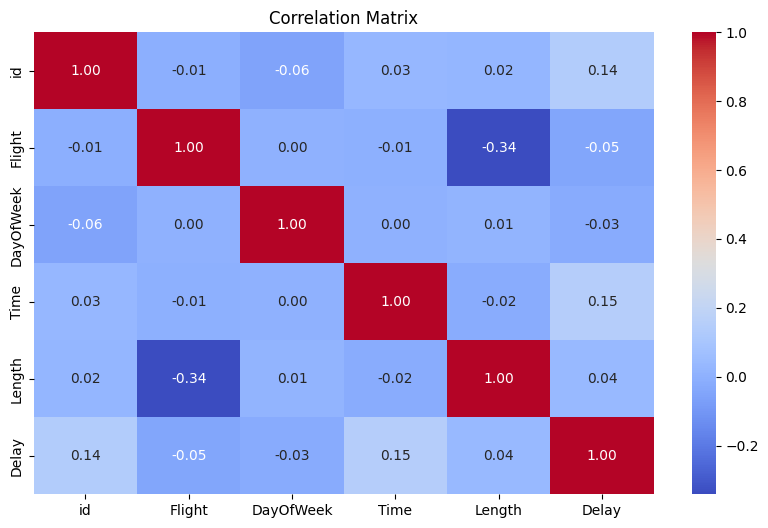

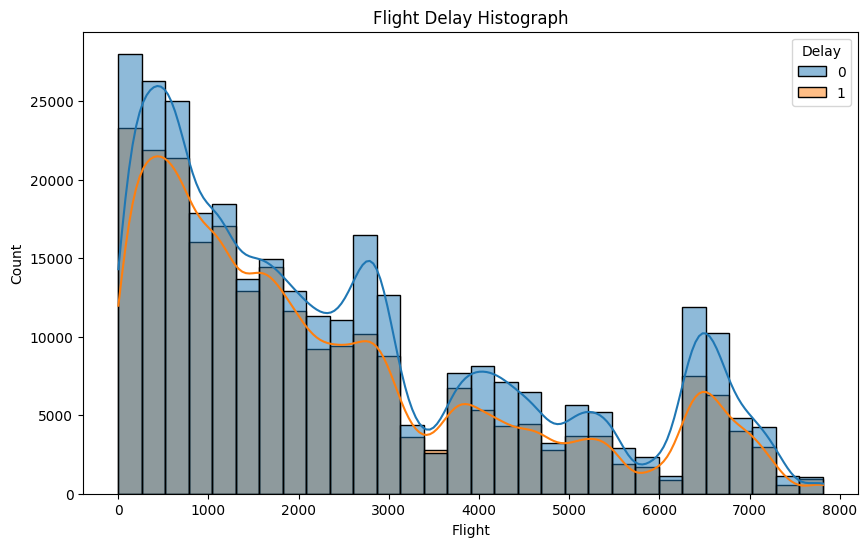

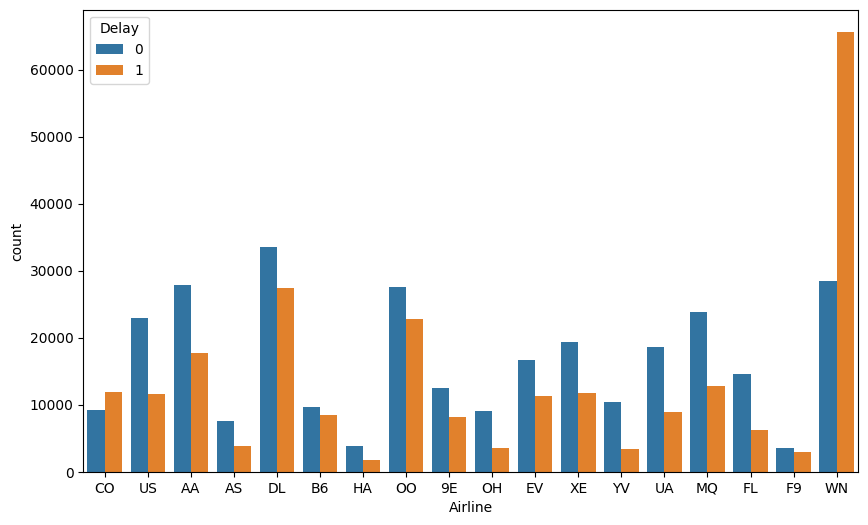

RandomForestClassifier


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install pyspark

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import numpy as np

conf = SparkConf().setAppName('matrix')
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SparkSession.builder\
.master("local")\
.appName("Colab")\
.config('spark,ui,port', '4050')\
.getOrCreate()

!wget -q 'https://drive.google.com/uc?export=download&id=16h5tXxW3JuJNUqJyGiykqispjP_CGNpa' -O 'Airlines.csv'

spark = SparkSession.builder.appName("Airlines Delay").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

#Table

csv_file_path = "Airlines.csv"
table = spark.read.csv(csv_file_path, header=True, inferSchema=True)
table.show()

#Heatmap

heatMap = table.toPandas()
plt.figure(figsize=(10, 6))
sns.heatmap(heatMap.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#Histograph

plt.figure(figsize=(10, 6))
sns.histplot(data=heatMap, x='Flight', hue='Delay', kde=True, bins=30)
plt.title("Flight Delay Histograph")
plt.xlabel("Flight")
plt.ylabel("Count")
plt.show()

#Data Processing

X_cat = table.select(['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek'])
X_num = table.drop('Airline').drop('AirportFrom').drop('AirportTo').drop('DayOfWeek').drop('Delay')
X_cat = pd.get_dummies(X_cat.toPandas(), drop_first=True)
X_cat.head()

#Delay Histograph

heatMap = table.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(data=heatMap, x='Airline', hue='Delay')
plt.show()

#Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

heatMap = table.toPandas()
y = heatMap['Delay']
X = pd.get_dummies(heatMap.drop('Delay', axis=1), drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_encoded = pd.get_dummies(heatMap, drop_first=True)
print('RandomForestClassifier')
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

#Decissiontree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

#Perception

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron

X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
model = Perceptron()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))